# `MF6ADJ` demonstration using the San Pedro model

In this notebook, we will see now `mf6adj` can be used with an MODFLOW-6 version of the famous San Pedro model of Leake and others (2010)

In [1]:
import os
import platform
import sys
import shutil
from datetime import datetime
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu

First we need to get the platform-specific binaries.  We have some strict control over these and they are stored at the root level in the repo in the `bin` dir.  Let's workout what path we should be using and the binary names we need:

In [2]:
if "linux" in platform.platform().lower():
    lib_name = os.path.join("..", "bin", "linux", "libmf6.so")
    mf6_bin = os.path.join("..", "bin", "linux", "mf6")
    local_lib_name = "./libmf6.so"
    local_mf6_bin = "./mf6"
    gg_bin = os.path.join("..", "bin", "linux", "gridgen")
elif "darwin" in platform.platform().lower() or "macos" in platform.platform().lower() and "arm" not in platform.platform().lower():
    lib_name = os.path.join("..", "bin", "mac", "libmf6.dylib")
    mf6_bin = os.path.join("..", "bin", "mac", "mf6")
    local_lib_name = "./libmf6.dylib"
    local_mf6_bin = "./mf6"
    gg_bin = os.path.join("..", "bin", "mac", "gridgen")
elif "darwin" in platform.platform().lower() or "macos" in platform.platform().lower() and "arm" in platform.platform().lower():
    lib_name = os.path.join("..", "bin", "mac", "libmf6_arm.dylib")
    mf6_bin = os.path.join("..", "bin", "mac", "mf6")
    local_lib_name = "./libmf6_arm.dylib"
    local_mf6_bin = "./mf6"
    gg_bin = os.path.join("..", "bin", "mac", "gridgen")
else:
    lib_name = os.path.join("..", "bin", "win", "libmf6.dll")
    mf6_bin = os.path.join("..", "bin", "win", "mf6.exe")
    local_lib_name = "libmf6.dll"
    local_mf6_bin = "mf6.exe"
    gg_bin = os.path.join("..", "bin", "win", "gridgen.exe")

In [3]:
lib_name

'../bin/mac/libmf6_arm.dylib'

In [4]:
assert os.path.exists(lib_name)
assert os.path.exists(mf6_bin)

Now let's get the model files we will be using - they are stored in the autotest directory

In [5]:
org_ws = os.path.join("..","autotest","sanpedro","mf6_transient_ghb")
assert os.path.exists(org_ws)

setup a local copy of the model files.  Also copy in the binaries we need for later....

In [6]:
ws = "sanpedro"
if os.path.exists(ws):
    shutil.rmtree(ws)
shutil.copytree(org_ws,ws)
shutil.copy2(lib_name,os.path.join(ws,os.path.split(local_lib_name)[1]))
shutil.copy2(mf6_bin,os.path.join(ws,os.path.split(local_mf6_bin)[1]))
shutil.copytree(os.path.join('..','autotest','xmipy'), os.path.join(ws, 'xmipy'))
shutil.copytree(os.path.join('..','autotest','bmipy'), os.path.join(ws, 'bmipy'))
shutil.copytree(os.path.join('..','autotest','modflowapi'), os.path.join(ws, 'modflowapi'))
shutil.copytree(os.path.join('..','autotest','flopy'), os.path.join(ws, 'flopy'))
shutil.copytree(os.path.join('..','mf6adj'), os.path.join(ws,"mf6adj"))

'sanpedro/mf6adj'

In [7]:
sim = flopy.mf6.MFSimulation.load(sim_ws=ws)
m = sim.get_model()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package rch...
    loading package ghb...
    loading package evt...
    loading package drn...
    loading package oc...
    loading package npf...
    loading package sto...
    loading package ic...
    loading package sfr...
  loading solution package sp_mf6...


In [8]:
ib = m.dis.idomain.array.astype(float)
ib[ib>0] = np.nan
ib_cmap = plt.get_cmap("Greys_r")
ib_cmap.set_bad(alpha=0.0)
def plot_model(k,arr,units=None):
    arr[~np.isnan(ib[k,:,:])] = np.nan
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    cb = ax.imshow(arr,cmap="plasma")
    plt.colorbar(cb,ax=ax,label=units)
    plt.imshow(ib[k,:,:],cmap=ib_cmap)
    return fig,ax

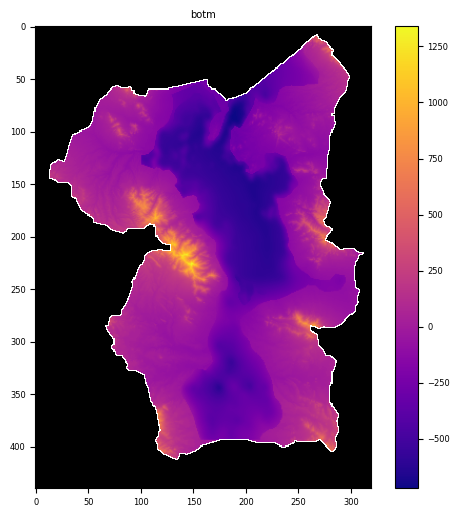

In [9]:
fig,ax = plot_model(4,m.dis.botm.array[4,:,:])
_ = ax.set_title("botm")

Run the existing model in our local workspace

In [10]:
pyemu.os_utils.run(local_mf6_bin,cwd=ws)

                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled Jun 21 2024 02:59:05 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthoriz

Now plot some heads...

Text(0.5, 1.0, 'layer 5 final heads')

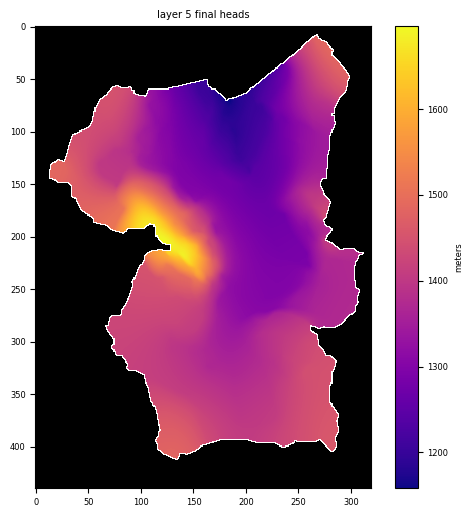

In [11]:
hds = flopy.utils.HeadFile(os.path.join(ws,"sp_mf6.hds"))
final_arr = hds.get_data()
fig,ax = plot_model(4,final_arr[4,:,:],units="meters")
ax.set_title("layer 5 final heads")

Ah so nice!  see the sfr "network" running north-south in the 15th column?

The main requirement to use `Mf6Adj` is an input file that describes the performance measures.  Luckily this file has a nice modern format like other MF6 input files.  Here we are going to make one programmatically... `MF6ADJ` supports so-called "flux-based" performance measures, which yield the sensitivity of a simulated flux to the model inputs.  This flux-based performance measure can be described very granularly just like the head-based performance measures.  So lets look at the sensitivity of the simulated sw-gw flux between the groundwater system and sfr across all output times...

In [12]:
pm_fname = "sfr_perfmeas.dat"
with open(os.path.join(ws,pm_fname),'w') as fpm:
    sfr_data = pd.DataFrame.from_records(m.sfr.packagedata.array)
    fpm.write("begin performance_measure swgw\n")
    for kper in range(sim.tdis.nper.data):
        for kij in sfr_data.cellid.values:
            fpm.write("{0} 1 {1} {2} {3} sfr-1 direct 1.0 -1.0e+30\n".format(kper+1,kij[0]+1,kij[1]+1,kij[2]+1))
    fpm.write("end performance_measure\n\n")

Ok, now we should be ready to go...the adjoint solution process requires running the model forward once and then solving for the adjoint state, which uses the forward solution components (i.e. the conductance matrix, the RHS, heads, saturation,etc). The adjoint state solution has two important characteristics:  its a linear (independent of the forward model's linearity) and it solves backward in time, starting with the last stress period - WAT?!

The adjoint solve is considerably slower than the forward solution, with most of the time being spent in the numpy sparse linear solve...#lyf

In [13]:
bd = os.getcwd()
os.chdir(ws)

In [14]:
forward_hdf5_name = "forward.hdf5"
start = datetime.now()
import mf6adj
adj = mf6adj.Mf6Adj(pm_fname,os.path.split(local_lib_name)[1],verbose_level=2)
adj.solve_gwf(hdf5_name=forward_hdf5_name) # solve the standard forward solution
dfsum = adj.solve_adjoint() # solve the adjoint state for each performance measure
adj.finalize() #release components
duration = (datetime.now() - start).total_seconds()
print("took:",duration)

...structured grid found
...starting flow solution at 2024-08-26 09:58:38
flow stress period,time step 1,1 converged with 4 iters, took  0.0057343 mins
flow stress period,time step 1,2 converged with 3 iters, took  0.0033104 mins
flow stress period,time step 1,3 converged with 2 iters, took  0.0026035 mins
flow stress period,time step 1,4 converged with 3 iters, took  0.0032546 mins
flow stress period,time step 1,5 converged with 4 iters, took  0.0039941 mins
flow stress period,time step 1,6 converged with 3 iters, took  0.0031467 mins
flow stress period,time step 1,7 converged with 3 iters, took  0.0031736 mins
flow stress period,time step 1,8 converged with 3 iters, took   0.003286 mins
flow stress period,time step 1,9 converged with 3 iters, took  0.0032873 mins
flow stress period,time step 1,10 converged with 4 iters, took  0.0037664 mins

...flow solution finished at 2024-08-26 09:58:41, took:   0.049817 mins


...structured grid found, shape: (5, 440, 320)
solving adjoint solutio

In [15]:
os.chdir(bd)

Boo ya!  done...let's see what happened...

In [16]:
[f for f in os.listdir(ws) if f.endswith("hdf5")]

['adjoint_solution_swgw_forward.hdf5', 'forward.hdf5']

`MF6ADJ` uses the widely available HDF5 format to store information - these files hold very low-level granular information about the adjoint solution.  However the `mf6adj.solve_adjoint()` method also returns a higher-level summary of the adjoint solution.  Let's look at it first:

In [17]:
type(dfsum)

dict

In [18]:
list(dfsum.keys())

['swgw']

In [19]:
dfhw = dfsum["swgw"]
dfhw

,k11,k33,wel6_q,rch6_recharge,drn-1_elev,drn-1_cond,ghb-1_bhead,ghb-1_cond,sfr-1_stage,sfr-1_cond,ss
node,,,,,,,,,,,
26747,-1.373537e+00,-0.153190,-9.275395e-01,-9.275395e-01,0.0,0.0,0.0,0.0,9952.489173,-0.522031,-2.399862e-05
26748,-3.439315e-02,-0.118518,-9.333998e-01,-9.333998e-01,0.0,0.0,0.0,0.0,8941.481316,0.111677,-1.625696e-05
27067,-1.755603e+00,-0.029435,-4.353839e-01,-4.353839e-01,0.0,0.0,0.0,0.0,164.989699,0.614818,-5.783787e-06
27068,1.417657e+00,-0.033066,-4.349976e-01,-4.349976e-01,0.0,0.0,0.0,0.0,7257.923783,-0.244655,-8.329353e-06
27387,1.127003e-01,-0.006774,-3.363489e-01,-3.363489e-01,0.0,0.0,0.0,0.0,0.000000,0.000000,-1.966265e-06
...,...,...,...,...,...,...,...,...,...,...,...
694854,-8.605314e-18,0.000000,-4.964766e-20,-4.964766e-20,0.0,0.0,0.0,0.0,0.000000,0.000000,-2.323405e-24
694855,-2.104227e-17,0.000000,-8.251959e-20,-8.251959e-20,0.0,0.0,0.0,0.0,0.000000,0.000000,1.154458e-24
694856,-2.386326e-17,0.000000,-1.291381e-19,-1.291381e-19,0.0,0.0,0.0,0.0,0.000000,0.000000,-2.807041e-23


those are the node-scale sensitivities to the sfr flux-based performance measure - some plots would be nice you say?!  Well this is most easily done with the HDF5 file itself...

In [20]:
result_hdf = "adjoint_solution_swgw_forward.hdf5"
hdf = h5py.File(os.path.join(ws,result_hdf),'r')
keys = list(hdf.keys())
keys.sort()
print(keys)

['composite', 'solution_kper:00000_kstp:00000', 'solution_kper:00000_kstp:00001', 'solution_kper:00000_kstp:00002', 'solution_kper:00000_kstp:00003', 'solution_kper:00000_kstp:00004', 'solution_kper:00000_kstp:00005', 'solution_kper:00000_kstp:00006', 'solution_kper:00000_kstp:00007', 'solution_kper:00000_kstp:00008', 'solution_kper:00000_kstp:00009']


The "composite" group has the sensitivities of the performance measure to the model inputs summed across all adjoint solutions...

In [21]:
grp = hdf["composite"]
plot_keys = [i for i in grp.keys() if len(grp[i].shape) == 3 and ("k33" in i or "wel" in i)]
plot_keys

['k33', 'wel6_q']

A simple routine to plot all these sensitivities....

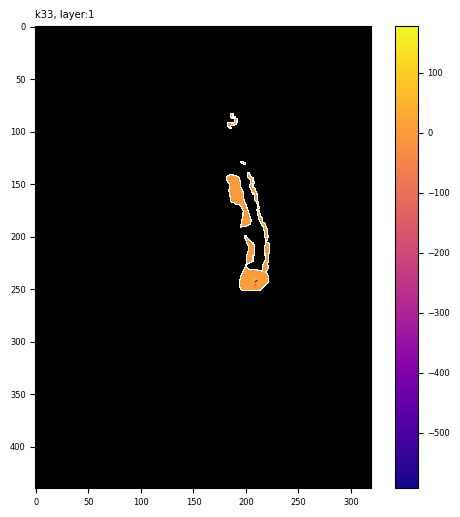

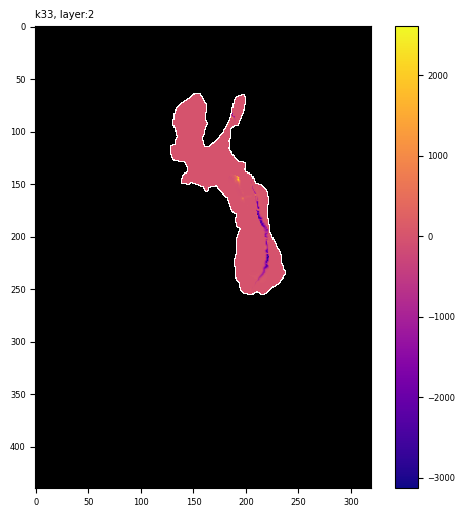

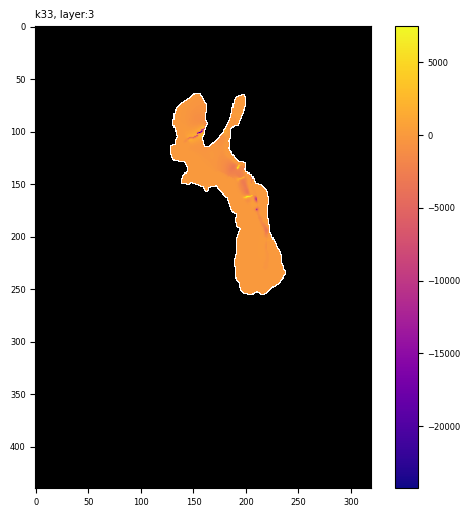

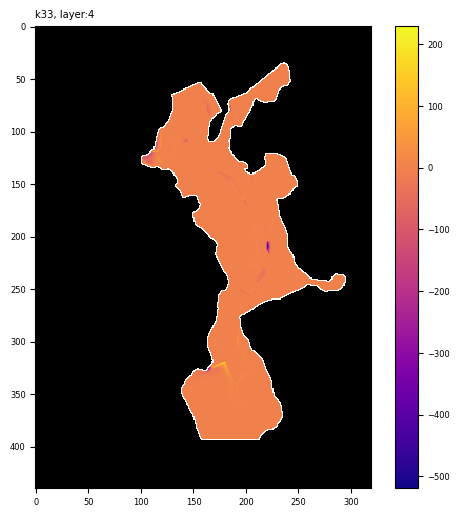

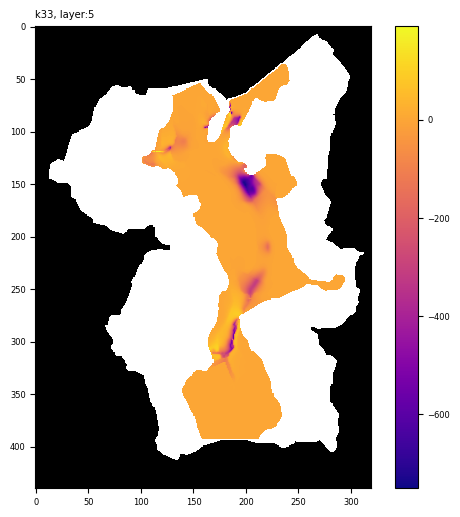

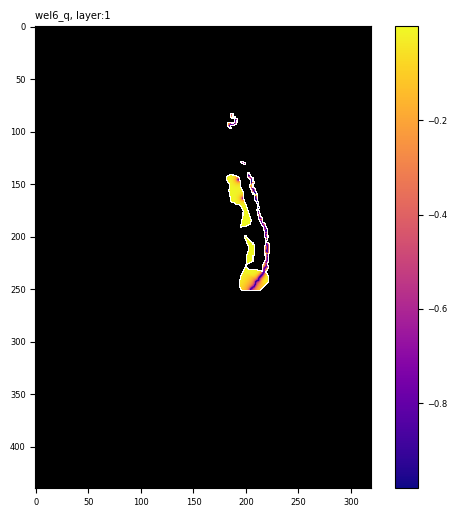

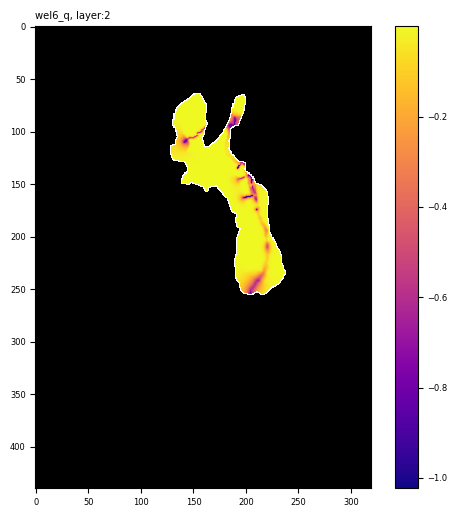

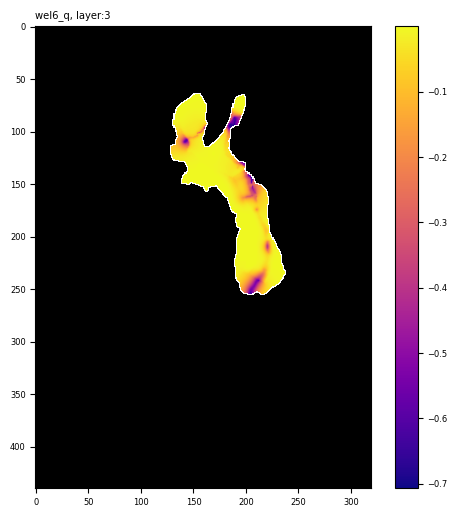

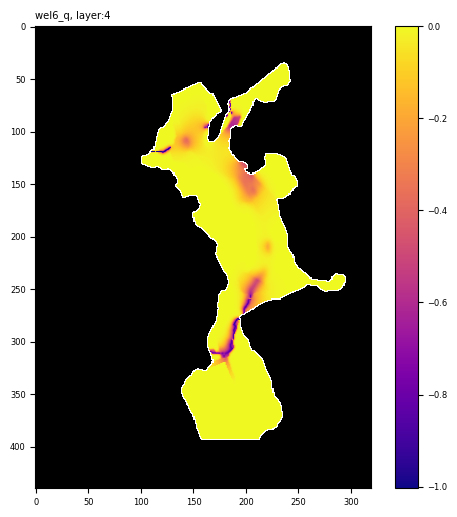

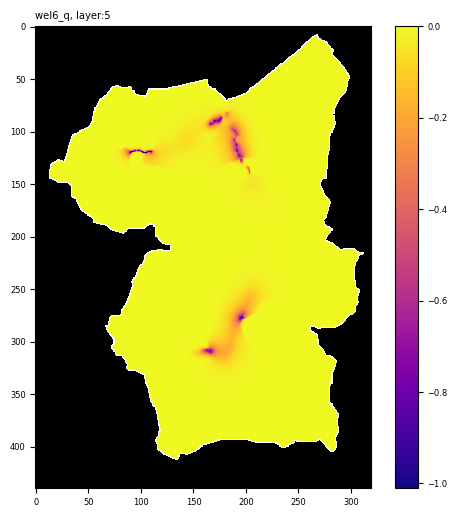

In [22]:
for pkey in plot_keys:
    arr = grp[pkey][:]
    for k,karr in enumerate(arr):
        karr[karr==0.0] = np.nan
        fig,ax = plot_model(k,karr)
        ax.set_title(pkey+", layer:{0}".format(k+1),loc="left")

There is one plot in there that is particularly well known with the practice of mapping so-called "capture fraction":

Text(0.0, 1.0, 'capture fraction layer 4')

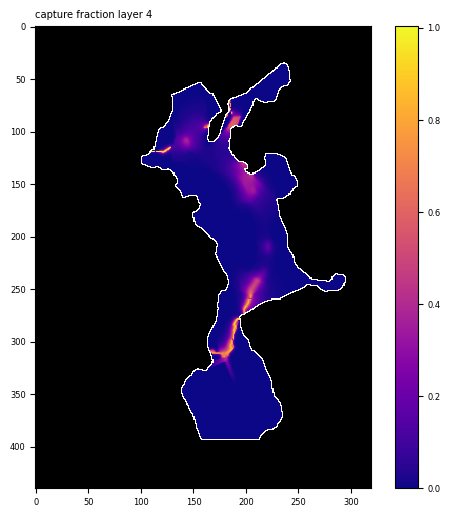

In [23]:
arr = grp["wel6_q"][3,:,:]
arr[arr==0.0] = np.nan
fig,ax = plot_model(3,np.abs(arr))
ax.set_title("capture fraction layer 4",loc="left")

What is being shown is the capture fraction: the proportion of groundwater "captured" from the simulated sw-gw flux if a groundwater well was to be added in a given model cell.  Normally, this would be calculated by mechanically adding a wel/specified flux boundary in each model cell, the running the model with this additional boundary cell, and recording how the sw-gw flux changed, and normalizing this change by the rate used in the added boundary cell, repeat for all active cells! - this can take long time to complete.  However, through the magic of the adjoint, the so-called "adjoint state" for this performance measure is simply negative of the capture fraction:  how the simulated gw-sw flux changes as a result of a unit injection of water in each active model cell...